# Customizing DAPS for New Inverse Problems

This notebook serves as a guide for integrating the DAPS framework into any new inverse problem. Below, we outline the key components required to leverage DAPS effectively:

- **Diffusion Model ($s_\theta$)**: Models the data distribution $p(x_0)$.
- **Forward Function ($A$)**: Defines the inverse problem, formulated as $y = A(x) + \epsilon$.
- **Evaluation (Optional)**: Assesses the quality of posterior samples.

## 0. Setup
Notice: we **highly recommend** to use local runtime by following [README](https://github.com/zhangbingliang2019/DAPS) to setup environment. **Please, make sure you are running in DAPS folder.**

If you still want to setup the environment on the cloud. Unconment and Run following cell to install requirements. If prompted with restart session, just restart and rerun the cell.

In [ ]:
# !git clone https://github.com/zhangbingliang2019/DAPS.git
# %cd /content/DAPS/
# !pip install -r requirements.txt

## 1. Diffusion Model

Regardless of the specific diffusion model you utilize, DAPS necessitates an additional wrapper capable of implementing one of the following two functions (refering to [`Diffusion Model`](https://github.com/zhangbingliang2019/DAPS/blob/fa34d9fbffc398398a1095b6dbdd711f50720600/model/__init__.py#L33C7-L33C21)):

- **Score Function (`score(x, sigma)`)**: Calculates the gradient of the log probability, represented as $\nabla_{x_t}\log p(x_t;\sigma_t)$. Here, `x` and `sigma` correspond to $x_t$ and $\sigma_t$, respectively.
- **Tweedie Function (`tweedie(x, sigma)`)**: Estimates the conditional expectation $\mathbb{E}_{x_0 \sim p(x_0 \mid x_t)}[x_0 \mid x_t]$, with `x` and `sigma` representing $x_t$ and $\sigma_t$.


In [2]:
from model import DiffusionModel, register_model

@register_model(name='my_model')
class MyDiffusionModel(DiffusionModel):
    def __init__(self):
        """
        Add your own parameters and functions here and implement one of following
        """
        pass

    def tweedie(self, x, sigma):
        """
        Compute the score function \nabla_{x_t} log p(x_t; sigma_t).

        Args:
            x (Tensor): Noisy input tensor at time t, shape [B, *data_shape].
            sigma (float): Noise level at time t.
        """
        pass

    def score(self, x, sigma):
        """
        Compute the expected clean data given noisy data.

        Args:
            x (Tensor): Noisy input tensor at time t, shape [B, *data_shape].
            sigma (float): Noise level at time t.
        """
        pass


    def get_in_shape(self):
        """Return the shape of the model's input data."""
        pass

/scratch/imaging/projects/bingliang/miniconda3/envs/DAPS-test/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Forward Function

DAPS mandates the use of a differentiable forward function, denoted as $A$, to address general noisy inverse problems formulated as $y = A(x) + \epsilon$.

- **Callable Method (`__call__(x)`)**: This method should be differentiable using PyTorch's autograd functionality. It encapsulates the forward function, ensuring that the gradients can be computed automatically.


In [3]:
from forward_operator import Operator, register_operator

@register_operator(name='my_forward')
class MyForwardFn(Operator):
    def __init__(self, sigma):
        """
        Add your own parameters and functions here
        """
        super().__init__(sigma)
        pass

    def __call__(self, x):
        """
        Apply operator to input data.

        Args:
            x (torch.Tensor): Input data tensor.==
        """
        pass


## 3. Evaluation (Optional)

The DAPS framework supports the integration of custom evaluation functions to assess the quality of solutions to inverse problems. These functions are optional but can be instrumental in fine-tuning model performance.
- **Criterion (`cmp`)**: Define the evaluation metric as either 'max' or 'min'.
    
- **Evaluation Method (`__call__`)**: Implement this method to execute the evaluation.


In [4]:
from eval import EvalFn, register_eval_fn

@register_eval_fn(name='my_eval')
class MyEvalFn(EvalFn):
    """
    choose between 'max' and 'min'
        * 'max': the higher the better
        * 'min': the lower the better
    """
    cmp = 'max'

    def __init__(self):
        """
        Add your own parameters and functions here and implement one of following
        """
        pass

    def __call__(self, gt, measurement, sample, reduction='none'):
        """
        Evaluates posterior sampling results against ground truth.

        Args:
            gt (torch.Tensor):
                Ground truth tensor, shape [B, *data.shape].
            measurement (torch.Tensor):
                Observed measurement tensor, shape [B, *measurement.shape].
            sample (torch.Tensor):
                Sampled tensor to evaluate, shape [B, *data.shape].
            reduction (str, optional):
                Reduction method, either 'none' or 'mean'. Defaults to 'none'.

        Returns:
            torch.Tensor:
                Evaluation metrics or individual loss values, depending on 'reduction'.
        """


In addition, to evaluate sample quality, we need a dataset for reference ground truth data.

In [5]:
from data import DiffusionData, register_dataset

@register_dataset(name='my_dataset')
class MyDataset(DiffusionData):
    def __init__(self):
        """
        Add your own parameters and functions here and implement one of following
        """
        pass

    def __getitem__(self, idx):
        """
        idx: index of the dataset
        """
        pass

    def __len__(self):
        """
        return the length of the dataset
        """
        pass

    def get_shape(self):
        """
        return the shape of your data. E.g. (3, 32, 32) for CIFAR10 images
        """
        pass

# Example on 2D Synthetic Dataset


## 1. Dataset

A 2D Gaussian with $2$ modes at $(-0.3, -0.4)$ and $(0.6, 0.5)$ with standard deviation $1.0$ and $2.0$ respectively.

In [6]:
from torch.distributions import Categorical
import torch
import numpy as np

@register_dataset(name='synthetic')
class Synthetic(DiffusionData):
    def __init__(self,dim=2, device='cuda'):
        self.dim = dim
        self.device = device
        self.mix_p = torch.tensor([0.5, 0.5]).to(self.device)
        self.p = Categorical(probs=self.mix_p)

        # gaussian parameter
        self.mu = torch.tensor([[-0.3, -0.4], [0.6, 0.5]]).to(self.device)
        self.noise = torch.tensor([1.0, 2.0]) * 1e-1
        self.noise = self.noise.to(self.device)

        # data sampling
        size = 1000

        self.idx = self.p.sample((size,))
        self.data = self.mu[self.idx] + self.noise[self.idx][:, None] * torch.randn(size, dim).to(self.device)
        self.data = self.data.to(self.device)

    def __getitem__(self, i):
        return self.data[i]

    def __len__(self):
        return len(self.data)

    def get_shape(self):
        return (self.dim,)

## 2. Diffusion Model
Instead of training a diffusion model, we directly use close-form analitical score function for convenience.

In [7]:
@register_model(name='synthetic_analitical')
class SyntheticModel(DiffusionModel):
    def __init__(self, data, device='cuda'):
        super().__init__()
        self.data = data
        self.mu = torch.nn.Parameter(data.mu, requires_grad=False).to(device)
        self.device=device

    def probs_ana(self, x, sigma):
        new_sigma_square = self.data.noise ** 2 + sigma ** 2
        kern = torch.exp(-((x[:, None] - self.data.mu[None]) ** 2).sum(dim=-1) / 2 / new_sigma_square[None]) / 2 / torch.pi / new_sigma_square[None]
        return kern @ self.data.mix_p

    def score(self, x, sigma):
        x_t = x.clone().requires_grad_(True)
        with torch.enable_grad():
            log_probs = self.probs_ana(x_t, sigma).log()
            score = torch.autograd.grad(outputs=log_probs, inputs=x_t, grad_outputs=torch.ones_like(log_probs))[0]
        return score.detach()

    def get_in_shape(self):
        return (self.data.dim, )
    

## 3. Forward Function
Here we use a man-made nonlinear forward function.

In [8]:
@register_operator(name='nonlinear_trap')
class NonLinearTrap(Operator):
    def __call__(self, x):
        y = torch.exp(-(x**2).sum(-1)/0.05) + torch.exp(-((x-0.5)**2).sum(-1)/0.05)
        return y.unsqueeze(-1)

## 4. Evaluation Function

We use [POT](https://pythonot.github.io/) to compute Wasserstein distance between sampled posterior and true posterior.

In [9]:
!pip install POT

In [10]:
from eval import EvalFn, register_eval_fn
import ot

def check(samples):
    idx = torch.isnan(samples)
    samples[idx] = torch.zeros_like(samples[idx])
    return samples

def get_gt_posterior(gt, operator, y, oversample=1, sigma=0.05):
    idx = []
    for _ in range(oversample):
        likelihood = operator.likelihood(gt, y)
        resampling = torch.multinomial(likelihood/likelihood.sum(), len(gt), replacement=True).to(gt.device)
        idx.append(resampling)
    idx = torch.cat(idx)
    return gt[idx]

def wasserstein(sample1, sample2):
    sample1, sample2 = check(sample1), check(sample2)
    a = np.ones((sample1.shape[0],)) / sample1.shape[0]
    b = np.ones((sample2.shape[0],)) / sample2.shape[0]
    C = ot.dist(sample1.numpy(), sample2.numpy(), metric='euclidean')
    w = ot.emd2(a, b, C)
    return w


@register_eval_fn(name='w2dist')
class Wasserstein(EvalFn):
    cmp = 'min'
    def __init__(self, operator):
        self.operator = operator

    def __call__(self, gt, measurement, sample, reduction='mean'):
        gt_sample = get_gt_posterior(gt, self.operator, measurement)
        gt_prob = np.ones((gt_sample.shape[0],)) / gt_sample.shape[0]

        pred_prob = np.ones((sample.shape[0],)) / sample.shape[0]
        dist = ot.dist(gt_sample.detach().cpu().numpy(), sample.detach().cpu().numpy(), metric='euclidean')
        w = ot.emd2(gt_prob, pred_prob, dist)

        if reduction == 'none':
            w = torch.tensor([w]*gt.shape[0], device=gt.device)
        else:
            w = torch.tensor([[w]], device=gt.device)
        return w



# Posterior Sampling with DAPS

Here we solve the following inverse problem,

$y = A(x)+\epsilon$

where $x=(0.5, 0.5)$, $\epsilon\sim N(0, 0.3)$

In [ ]:
#@title DAPS Hyperparameter

from omegaconf import OmegaConf
def load_conf(file_path):
    conf = OmegaConf.load(file_path)
    return conf

# for pixel sapce diffusion model
base_config_file = "edm_daps" # @param ["edm_daps"]
base_config = load_conf(f"configs/sampler/{base_config_file}.yaml")

# annealing scheduler
annealing_steps = 50 # @param {type:"integer"}
base_config.annealing_scheduler_config.num_steps = annealing_steps

annealing_sigma_max = 1 #@param {"type": "number"}
base_config.annealing_scheduler_config.sigma_max = annealing_sigma_max

annealing_sigma_min = 0.03 #@param {"type": "number"}
base_config.annealing_scheduler_config.sigma_min = annealing_sigma_min

# diffusion scheduler
diffusion_steps = 10 # @param {type:"integer"}
base_config.diffusion_scheduler_config.num_steps = diffusion_steps

# lgvd config
mcmc_sampler_config = OmegaConf.create()
langevin_steps = 100 # @param {type:"integer"}
mcmc_sampler_config.num_steps = langevin_steps

lr = 1e-4 #@param {"type": "number"}
mcmc_sampler_config.lr = lr

tau = 0.1 #@param {"type": "number"}
mcmc_sampler_config.tau = tau

lr_min_ratio = 1 #@param {"type": "number"}
mcmc_sampler_config.lr_min_ratio = lr_min_ratio

batch_size = 1000 # @param {type:"number"}
sigma = 0.3 # @param {type:"number"}

In [12]:
from sampler import get_sampler
from eval import Evaluator

device = 'cuda' if torch.cuda.is_available() else 'cpu'
data = Synthetic(2, device)
model = SyntheticModel(data, device)
operator = NonLinearTrap(sigma=sigma)
eval_fn = Wasserstein(operator)

# reference ground truth points
gt = data.get_data(batch_size, 0)
measurement = operator(torch.tensor([[0.5, 0.5]]).to(device))

evaluator = Evaluator((eval_fn,))

In [13]:
sampler = get_sampler(**base_config, mcmc_sampler_config=mcmc_sampler_config)
xT = sampler.get_start(gt.shape[0], model)
x0 = sampler.sample(model, xT, operator, measurement, evaluator, verbose=True, record=True, gt=gt)
trajectory = sampler.trajectory.compile()

100%|██████████| 50/50 [00:30<00:00,  1.63it/s, x0hat_w2dist=0.08, x0y_w2dist=0.09]


# Visualization

First we visualize the ground truth prior and posterior distribution.

In [14]:
!pip install seaborn

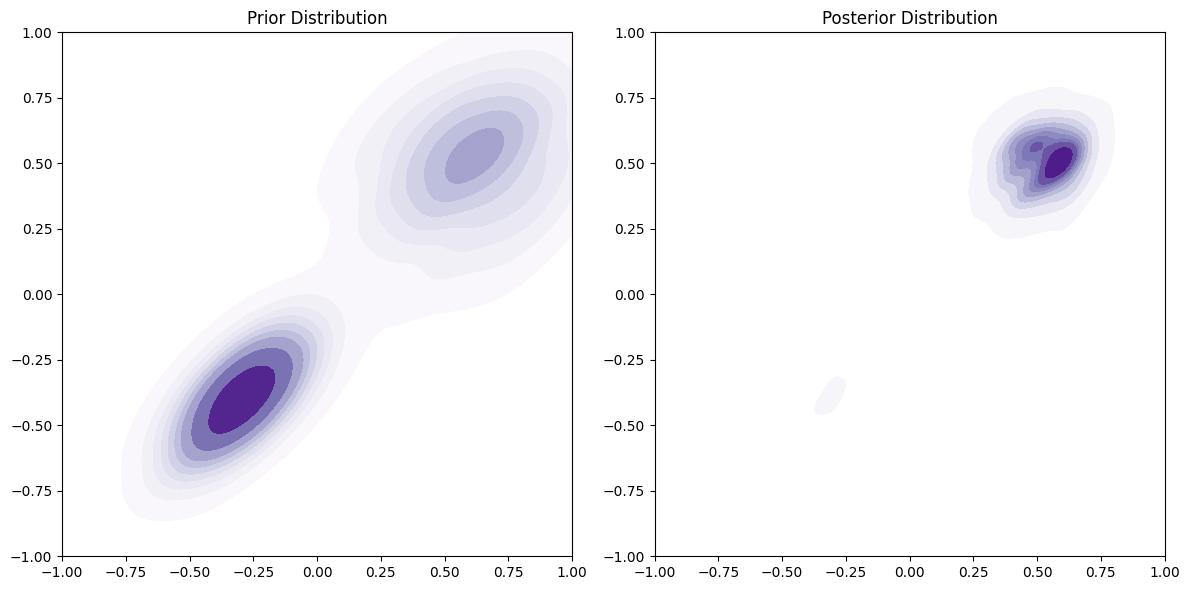

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

lx, rx = -1, 1
ly, ry = -1, 1

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for Prior Distribution
sns.kdeplot(x=gt[:, 0].cpu(), y=gt[:, 1].cpu(), cmap="Purples", fill=True, alpha=1, ax=axs[0])
axs[0].set_xlim(lx, rx)
axs[0].set_ylim(ly, ry)
axs[0].set_title('Prior Distribution')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

# Plot for Posterior Distribution
posterior_sample = get_gt_posterior(gt, operator, measurement, 1)
sns.kdeplot(x=posterior_sample[:, 0].cpu(), y=posterior_sample[:, 1].cpu(), cmap="Purples", fill=True, alpha=1, ax=axs[1])
axs[1].set_xlim(lx, rx)
axs[1].set_ylim(ly, ry)
axs[1].set_title('Posterior Distribution')
axs[1].set_xlabel('')
axs[1].set_ylabel('')

# Show the plot
plt.tight_layout()
plt.show()


Then we visualize the sampled posterior distribution and one sample trajectory.

Text(0, 0.5, '')

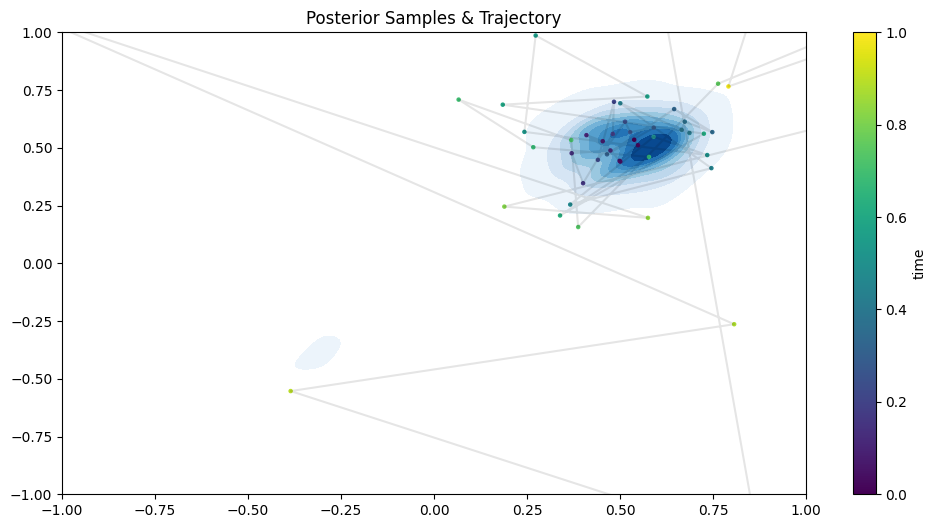

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 6))
# plot distribution
sns.kdeplot(x=posterior_sample[:,0].cpu(), y=posterior_sample[:,1].cpu(), cmap="Blues", fill=True, alpha=1)

# plot one trajectory
N = annealing_steps
t = np.linspace(0, 1, N)[::-1]
x, y = torch.chunk(trajectory.tensor_data['xt'].cpu()[:,0], 2, dim=-1)
x, y = x.flatten(), y.flatten()
plt.scatter(x, y, c=t, s=5)
plt.plot(x, y, alpha=0.1, c='black')

plt.colorbar(label='time')
plt.xlim(lx, rx)
plt.ylim(ly, ry)
plt.title('Posterior Samples & Trajectory')
plt.xlabel('')
plt.ylabel('')